**This project was made by student of BDA 2102. 
Turganbekov Rahat <br> Topic.  <br> Brain Tumor - сlassification of the following diseases Glioma, Meningioma, Pituitary and also Notumor.**

**Introduction**. <br>
Brain tumors are a significant health concern, with more than 700,000 new cases diagnosed each year worldwide. It is a growth of cells in the brain or near it. Brain tumors can happen in the brain tissue. Brain tumors also can happen near the brain tissue. Nearby locations include nerves, the pituitary gland, the pineal gland, and the membranes that cover the surface of the brain. Accurate and timely diagnosis is crucial for effective treatment and management of the condition. One approach to improve brain tumor diagnosis is to develop machine learning models that can automatically analyze medical images to detect a tumor and classify its type. In this project, we focus on the classification of four types of brain tumors - glioma, meningioma, pituitary, and no tumor.

**Glioma** <br> Glioma is a type of brain tumor that arises from the glial cells in the brain. Glial cells are non-neuronal cells that provide structural and functional support to the neurons in the brain. Gliomas can be either benign (non-cancerous) or malignant (cancerous) and can occur in various regions of the brain.

**Meningioma** <br> Meningioma is a type of brain tumor that arises from the meninges, which are the protective layers of tissue that cover the brain and spinal cord. Meningiomas are typically benign (non-cancerous), but in rare cases, they can be malignant (cancerous). Meningiomas can occur in various regions of the brain and spinal cord and can range in size from very small to very large.

**Pituitary** <br> Pituitary tumors that develop in the pituitary gland, a small gland located at the base of the brain. The pituitary gland produces hormones that regulate many functions in the body, including growth and development, metabolism, and reproduction. Most pituitary tumors are benign (non-cancerous) and are called adenomas.

**No tumor** <br> The "no tumor" class includes images of healthy brain tissue, as well as images that do not show any visible tumor.

**Data** <br> These diagnoses are typically made through imaging studies such as Magnetic Resonance Imaging (MRI) or Computed Tomography (CT) scans. These scans can show the location and size of the tumor and help to determine trumor type

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers,models
import IPython.display as display
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import scikitplot as skplt
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
import numpy as np
import random
import cv2
import os
print(tf.__version__)

2.11.0


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

train_directory = '/content/gdrive/MyDrive/Training/' 
test_directory = '/content/gdrive/MyDrive/Testing/' 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**The pie chart below shows the percentage distribution of training images for each class.**

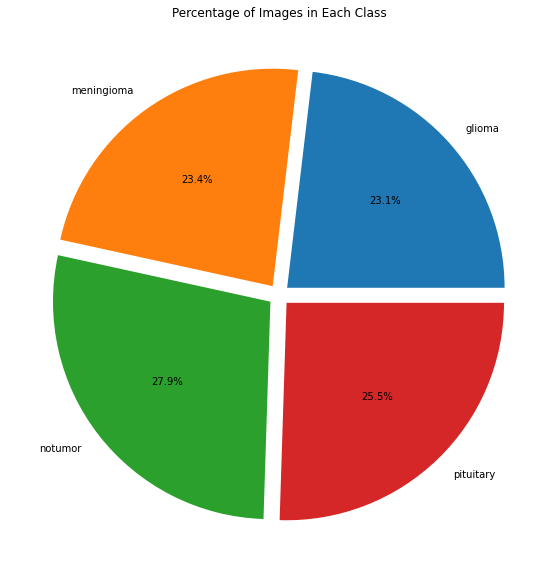

In [ ]:
plt.figure(figsize=(14,10),edgecolor = 'white')
class_counts = {}
for class_folder in os.listdir(train_directory):
    if os.path.isdir(os.path.join(train_directory, class_folder)):
        class_counts[class_folder] = len(os.listdir(os.path.join(train_directory, class_folder)))


total_images = sum(class_counts.values())
class_percentages = {class_name: count/total_images for class_name, count in class_counts.items()}


plt.pie(class_percentages.values(), labels=class_percentages.keys(), autopct='%1.1f%%', explode = [0.05, 0.05, 0.05, 0.05])
plt.title('Percentage of Images in Each Class')
plt.show()

**The bar chart below shows total number of images in directories**

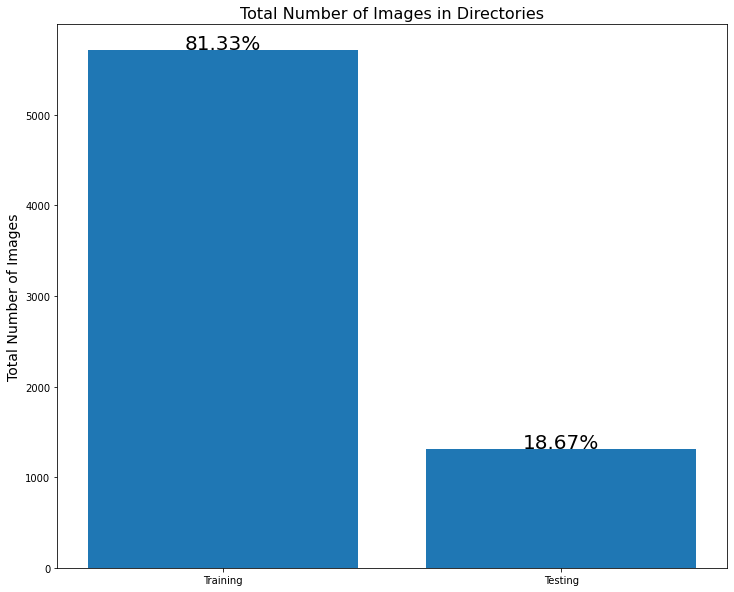

In [ ]:
def count_images(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".jpg") :
                count += 1
    return count


train_total_images = count_images(train_directory)
test_total_images = count_images(test_directory)

train_percentage = (train_total_images / (train_total_images + test_total_images)) * 100
test_percentage = (test_total_images / (train_total_images + test_total_images)) * 100
fig = plt.figure(figsize=(12, 10))

plt.bar(['Training', 'Testing'], [train_total_images, test_total_images])
plt.ylabel('Total Number of Images',fontsize=14)
plt.title('Total Number of Images in Directories',fontsize=16)

plt.text(0, train_total_images + 10, f'{train_percentage:.2f}%', ha='center',fontsize=20)
plt.text(1, test_total_images + 10, f'{test_percentage:.2f}%', ha='center',fontsize=20)

plt.show()

**Examples of each type of brain tumor**

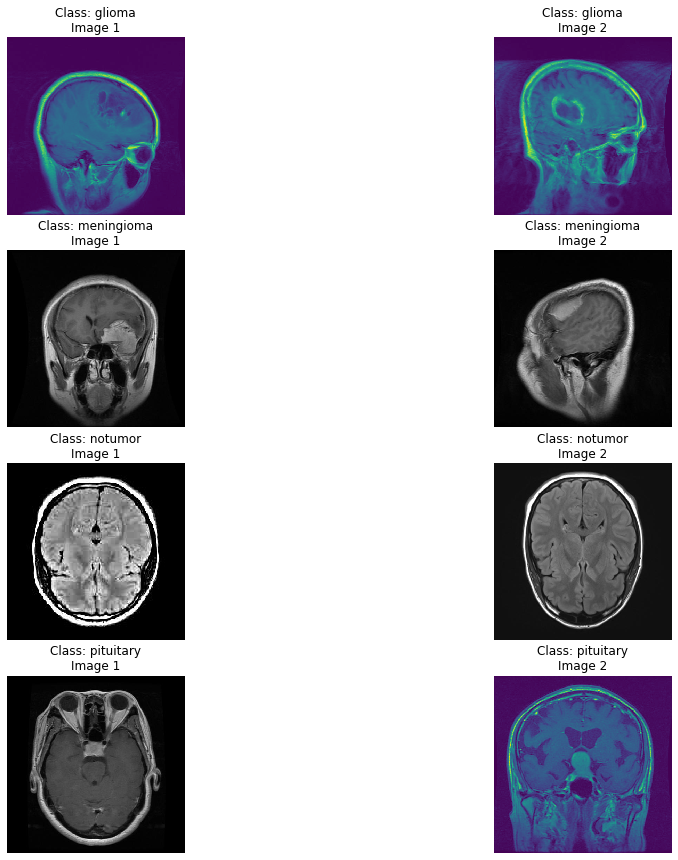

In [ ]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

fig, axs = plt.subplots(len(classes), 2, figsize=(16, 15))

for i, class_name in enumerate(classes):
    class_directory = os.path.join(train_directory, class_name)
    image_files = [f for f in os.listdir(class_directory) if f.endswith('.jpg')]
    random.shuffle(image_files)
    for j in range(2):
        image_file = image_files[j]
        image_path = os.path.join(class_directory, image_file)
        axs[i, j].imshow(Image.open(image_path), interpolation='nearest')
        axs[i, j].axis('off')
        axs[i, j].set_title(f"Class: {class_name}\nImage {j+1}")
        
plt.show()

**Data preparation**

In [116]:
labels = os.listdir(train_directory) 
amount_train = {label: len(os.listdir(os.path.join(train_directory, label))) for label in labels} 
amount_test = {label: len(os.listdir(os.path.join(test_directory, label))) for label in labels} 
 
x_train, y_train = [], [] 
x_test, y_test = [], [] 
  
for label in labels: 
    path = os.path.join(train_directory, label) 
    for file_name in tqdm(os.listdir(path)): 
        file_path = os.path.join(path, file_name) 
        img = cv2.imread(file_path, 1) 
        img = cv2.resize(img, (128, 128)) 
        x_train.append(img) 
        y_train.append(label) 
 

100%|██████████| 1457/1457 [00:07<00:00, 193.11it/s]


In [117]:
x_train = np.array(x_train) 
y_train = np.array(y_train) 

In [118]:
for label in labels: 
    path = os.path.join(test_directory, label) 
    for file_name in tqdm(os.listdir(path)): 
        file_path = os.path.join(path, file_name) 
        img = cv2.imread(file_path, 1) 
        img = cv2.resize(img, (128, 128)) 
        x_test.append(img) 
        y_test.append(label) 

100%|██████████| 300/300 [00:01<00:00, 219.43it/s]


In [119]:
x_test = np.array(x_test) 
y_test = np.array(y_test)

**Converting y_train, y_test lables to one hot encoded vectors**

In [ ]:
x_train, y_train = shuffle(x_train, y_train) 
x_test, y_test = shuffle(x_test, y_test)

y_train = tf.keras.utils.to_categorical([labels.index(i) for i in y_train]) 
y_test = tf.keras.utils.to_categorical([labels.index(i) for i in y_test])

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255, 
    width_shift_range = 0.1, 
    height_shift_range = 0.1,
    validation_split = 0.1,) 
 
test_datagen = ImageDataGenerator(rescale = 1./255) 
 
train_gen = train_datagen.flow( 
    x_train, y_train, 
    batch_size = 32) 
 
test_gen = test_datagen.flow( 
    x_test, y_test, 
    shuffle=False, 
    batch_size = 32) 
 
val_gen = train_datagen.flow( 
  x_train, y_train, 
  batch_size=32) 
 
for data_batch, labels_batch in train_gen: 
    print('data batch shape:', data_batch.shape) 
    print('labels batch shape:', labels_batch.shape) 
    break

data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 4)


**First model**

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, 3, activation='relu', input_shape=[128, 128, 3]))
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(2,2))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4, activation='softmax'))


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(train_gen,validation_data=val_gen, epochs=10)

Epoch 1/10
179/179 [==============================] - 820s 5s/step - loss: 1.4715 - accuracy: 0.5945 - val_loss: 5.1682 - val_accuracy: 0.2560
Epoch 2/10
179/179 [==============================] - 811s 5s/step - loss: 0.7784 - accuracy: 0.7120 - val_loss: 2.1260 - val_accuracy: 0.5056
Epoch 3/10
179/179 [==============================] - 748s 4s/step - loss: 0.6238 - accuracy: 0.7698 - val_loss: 0.6746 - val_accuracy: 0.7547
Epoch 4/10
179/179 [==============================] - 788s 4s/step - loss: 0.5748 - accuracy: 0.7995 - val_loss: 1.1763 - val_accuracy: 0.6684
Epoch 5/10
179/179 [==============================] - 788s 4s/step - loss: 0.5055 - accuracy: 0.8018 - val_loss: 0.6257 - val_accuracy: 0.7693
Epoch 6/10
179/179 [==============================] - 798s 4s/step - loss: 0.4567 - accuracy: 0.8358 - val_loss: 0.4166 - val_accuracy: 0.8466
Epoch 7/10
179/179 [==============================] - 785s 4s/step - loss: 0.4264 - accuracy: 0.8403 - val_loss: 0.4048 - val_accuracy: 0.8473

In [ ]:
model.save('first_model.h5')

In [ ]:
#model = tf.keras.models.load_model('/content/first_model.h5')

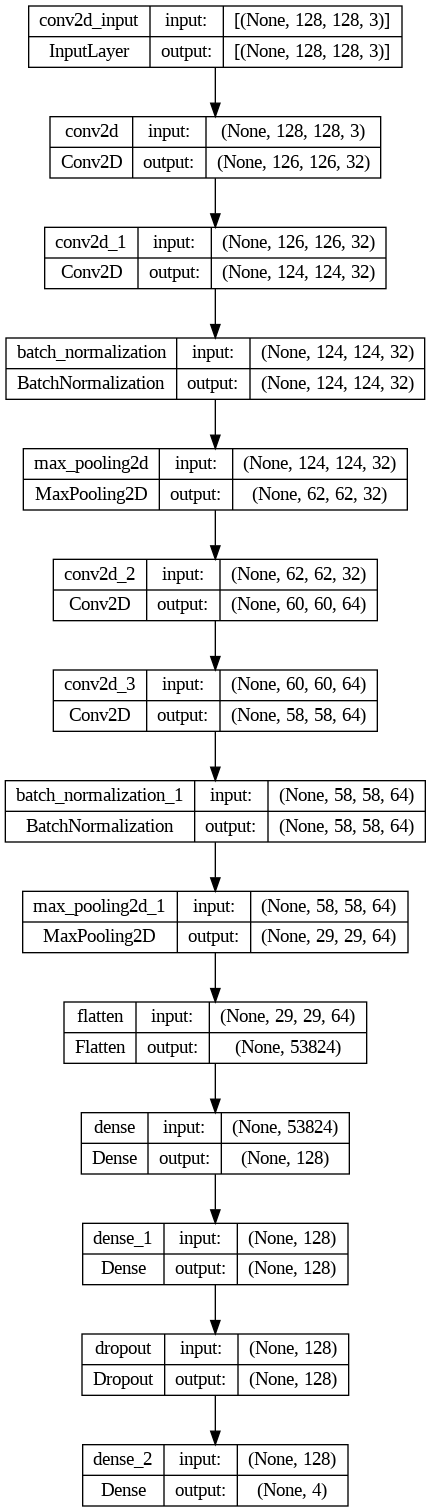

In [ ]:
tf.keras.utils.plot_model(model,show_shapes = True)

In [ ]:
def plot_loss_accuracy(history): 
    fig, ax = plt.subplots(1, 2, figsize=(15,5)) 
    ax[0].plot(history.history['loss'], label='Train_loss') 
    ax[0].plot(history.history['val_loss'], label='Val_loss', color='r') 
    ax[0].set_title('Loss over epochs') 
    ax[0].set_xlabel('Epoch') 
    ax[0].set_ylabel('Loss') 
    ax[0].legend() 
     
    ax[1].plot(history.history['accuracy'], label='Train_accuracy') 
    ax[1].plot(history.history['val_accuracy'], label='Val_accuracy', color='r') 
    ax[1].set_title('Accuracy over epochs') 
    ax[1].set_xlabel('Epoch') 
    ax[1].set_ylabel('Accuracy') 
    ax[1].legend() 
    plt.show()


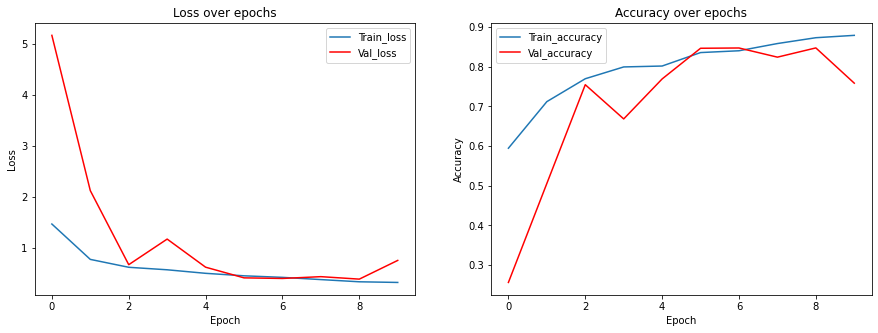

In [ ]:
plot_loss_accuracy(history)

**Second model**

In [ ]:
model2 = models.Sequential() 
model2.add(layers.Conv2D(32, 3, activation='relu', input_shape=(128, 128, 3))) 
model2.add(layers.MaxPooling2D(pool_size=(2,2))) 
 
model2.add(layers.Conv2D(64, 3, activation='relu')) 
model2.add(layers.MaxPooling2D(pool_size=(2,2))) 
 
model2.add(layers.Conv2D(128, 3, activation='relu')) 
model2.add(layers.MaxPooling2D(pool_size=(2,2))) 
 
model2.add(layers.Flatten()) 
model2.add(layers.Dense(512, activation='relu')) 
model2.add(layers.Dense(4, activation='softmax')) 


In [ ]:
model2.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy']) 
history2 = model2.fit(train_gen, validation_data=val_gen,  epochs=10)

Epoch 1/10
179/179 [==============================] - 341s 2s/step - loss: 0.8772 - accuracy: 0.6285 - val_loss: 0.5327 - val_accuracy: 0.7945
Epoch 2/10
179/179 [==============================] - 341s 2s/step - loss: 0.5418 - accuracy: 0.7939 - val_loss: 0.4871 - val_accuracy: 0.8071
Epoch 3/10
179/179 [==============================] - 340s 2s/step - loss: 0.4590 - accuracy: 0.8228 - val_loss: 0.3788 - val_accuracy: 0.8594
Epoch 4/10
179/179 [==============================] - 343s 2s/step - loss: 0.3944 - accuracy: 0.8512 - val_loss: 0.3856 - val_accuracy: 0.8424
Epoch 5/10
179/179 [==============================] - 405s 2s/step - loss: 0.3430 - accuracy: 0.8692 - val_loss: 0.2828 - val_accuracy: 0.8943
Epoch 6/10
179/179 [==============================] - 341s 2s/step - loss: 0.2863 - accuracy: 0.8915 - val_loss: 0.2770 - val_accuracy: 0.8894
Epoch 7/10
179/179 [==============================] - 344s 2s/step - loss: 0.2641 - accuracy: 0.8974 - val_loss: 0.2927 - val_accuracy: 0.8939

In [ ]:
model2.save('second_model.h5')

In [ ]:
#model = tf.keras.models.load_model('/content/second_model.h5')

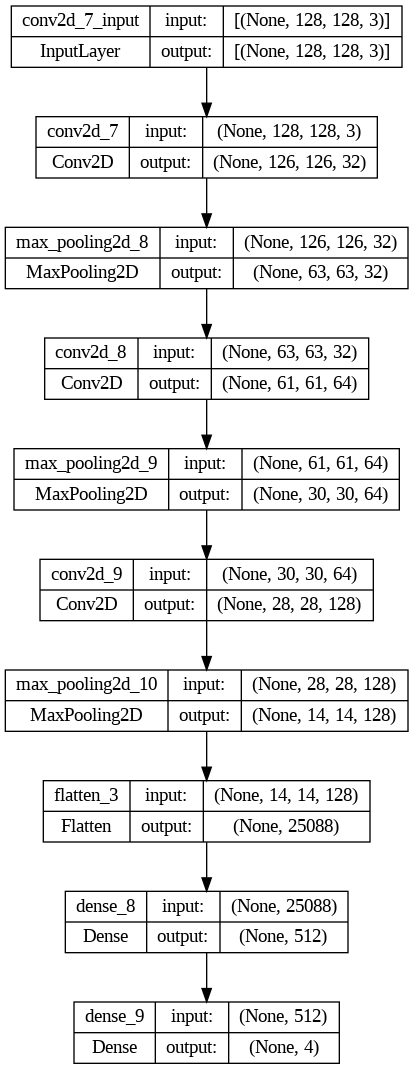

In [ ]:
tf.keras.utils.plot_model(model2,show_shapes = True)

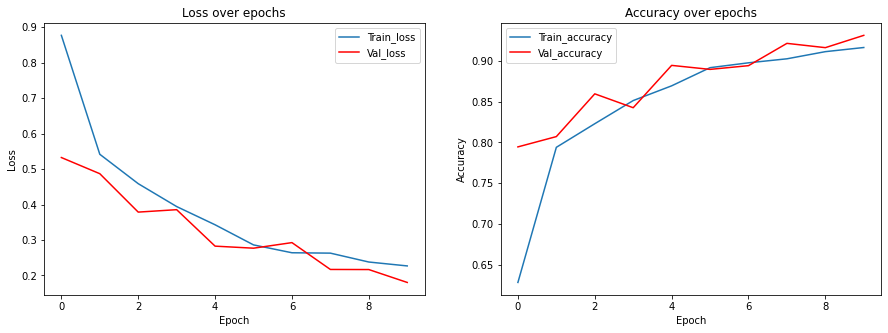

In [ ]:
plot_loss_accuracy(history2)

**Third model**

In [ ]:
model_tr = ResNet50V2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in model_tr.layers[:-4]:
    layer.trainable = False


model3 = models.Sequential()
model3.add(model_tr)
model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(4, activation='softmax'))  


In [ ]:
model3.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
history3 = model3.fit(train_gen,validation_data=val_gen,epochs=10)

Epoch 1/10
179/179 [==============================] - 752s 4s/step - loss: 0.9115 - accuracy: 0.7568 - val_loss: 0.4475 - val_accuracy: 0.8424
Epoch 2/10
179/179 [==============================] - 696s 4s/step - loss: 0.5014 - accuracy: 0.8314 - val_loss: 0.3451 - val_accuracy: 0.8754
Epoch 3/10
179/179 [==============================] - 749s 4s/step - loss: 0.4072 - accuracy: 0.8603 - val_loss: 0.4464 - val_accuracy: 0.8505
Epoch 4/10
179/179 [==============================] - 691s 4s/step - loss: 0.3625 - accuracy: 0.8725 - val_loss: 0.3984 - val_accuracy: 0.8584
Epoch 5/10
179/179 [==============================] - 746s 4s/step - loss: 0.3270 - accuracy: 0.8859 - val_loss: 0.3923 - val_accuracy: 0.8761
Epoch 6/10
179/179 [==============================] - 699s 4s/step - loss: 0.3277 - accuracy: 0.8881 - val_loss: 0.2222 - val_accuracy: 0.9179
Epoch 7/10
179/179 [==============================] - 692s 4s/step - loss: 0.2550 - accuracy: 0.9097 - val_loss: 0.2233 - val_accuracy: 0.9217

In [ ]:
model3.save('third_model.h5')

In [ ]:
#model3 = tf.keras.models.load_model('/content/third_model.h5')

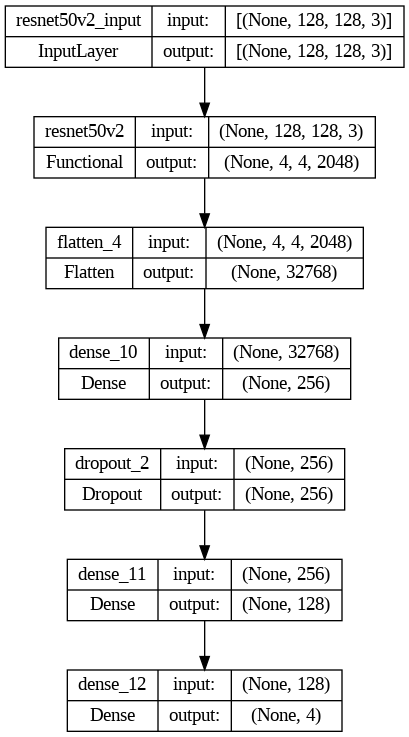

In [ ]:
tf.keras.utils.plot_model(model3,show_shapes = True)

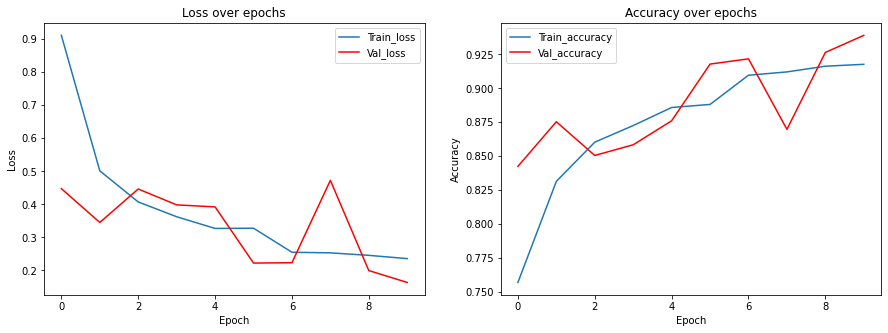

In [ ]:
plot_loss_accuracy(history3)

**Performance comparison by <br> 1.Confusion matrix <br> 2.ROC AUC curve  <br> 3.Metrics table** 

In [ ]:
labels_pred= model.predict(test_gen) 
y_pred = tf.argmax(labels_pred, axis=1) 
y_true = tf.argmax(y_test, axis = 1)

41/41 [==============================] - 34s 830ms/step


In [ ]:
labels_pred2= model2.predict(test_gen) 
y_pred2 = tf.argmax(labels_pred2, axis=1) 
y_true2 = tf.argmax(y_test, axis = 1)

41/41 [==============================] - 14s 342ms/step


In [ ]:
labels_pred3 = model3.predict(test_gen) 
y_pred3 = tf.argmax(labels_pred3, axis=1) 
y_true3 = tf.argmax(y_test, axis = 1)

41/41 [==============================] - 77s 2s/step


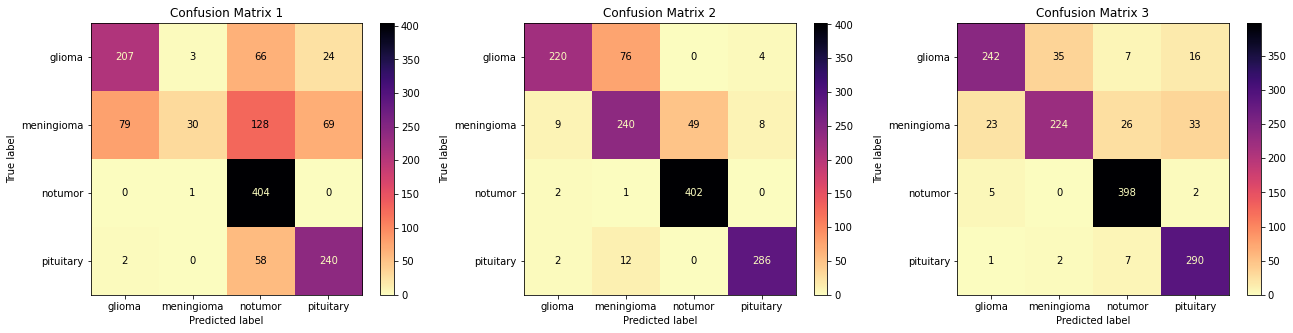

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(22, 5)) 
 
# Create the confusion matrix displays and plot them on the appropriate subplot 
disp1 = ConfusionMatrixDisplay.from_predictions( y_true, y_pred, display_labels=labels, cmap=plt.cm.get_cmap('magma_r'), ax=axes[0]) 
axes[0].set_title('Confusion Matrix 1') 
 
disp2 = ConfusionMatrixDisplay.from_predictions(y_true2, y_pred2, display_labels=labels, cmap=plt.cm.get_cmap('magma_r'), ax=axes[1]) 
axes[1].set_title('Confusion Matrix 2') 
 
disp3 = ConfusionMatrixDisplay.from_predictions(y_true3, y_pred3, display_labels=labels, cmap=plt.cm.get_cmap('magma_r'), ax=axes[2]) 
axes[2].set_title('Confusion Matrix 3') 
 
plt.show()

Text(0.5, 1.0, 'ROC-AUC curve 3')

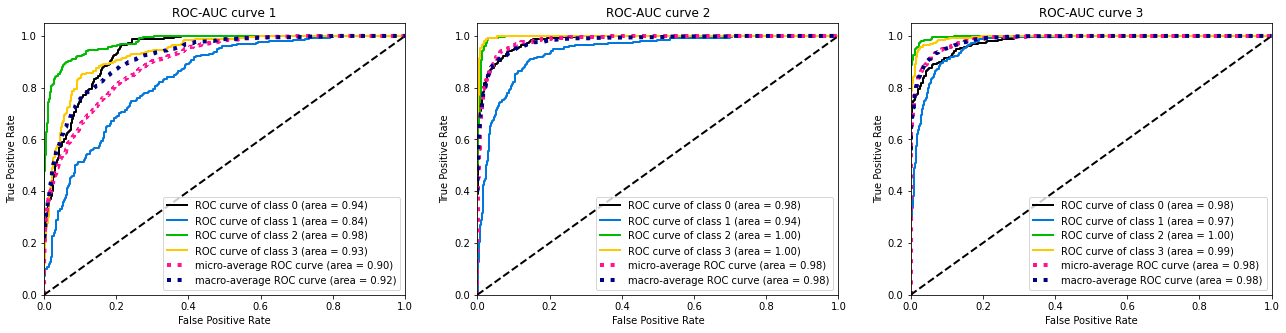

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(22, 5))
disp1 = skplt.metrics.plot_roc(y_true, labels_pred, ax=axes[0])
axes[0].set_title('ROC-AUC curve 1') 
disp2 = skplt.metrics.plot_roc(y_true2, labels_pred2, ax=axes[1])
axes[1].set_title('ROC-AUC curve 2')  
disp13= skplt.metrics.plot_roc(y_true3, labels_pred3, ax=axes[2])
axes[2].set_title('ROC-AUC curve 3')

In [ ]:
print('                 Metrics table for First Model') 
print(classification_report(y_true, y_pred, target_names=labels))  
print('\n') 
print('                 Metrics table for Second Model') 
print(classification_report(y_true2, y_pred2, target_names=labels))  
print('\n') 
print('                 Metrics table for Third Model') 
print(classification_report(y_true3, y_pred3, target_names=labels))

                 Metrics table for First Model
              precision    recall  f1-score   support

      glioma       0.72      0.69      0.70       300
  meningioma       0.88      0.10      0.18       306
     notumor       0.62      1.00      0.76       405
   pituitary       0.72      0.80      0.76       300

    accuracy                           0.67      1311
   macro avg       0.73      0.65      0.60      1311
weighted avg       0.73      0.67      0.61      1311



                 Metrics table for Second Model
              precision    recall  f1-score   support

      glioma       0.94      0.73      0.83       300
  meningioma       0.73      0.78      0.76       306
     notumor       0.89      0.99      0.94       405
   pituitary       0.96      0.95      0.96       300

    accuracy                           0.88      1311
   macro avg       0.88      0.87      0.87      1311
weighted avg       0.88      0.88      0.87      1311



                 Metrics table 

**Checking the validity of the model on your own MRI image**

In [ ]:
def predict_class(model, img_path):
    classes = ['glioma', 'meningioma', 'notumor', 'pituitary'] 
    img = image.load_img(img_path, target_size = (128, 128))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    
    # Predict the class probabilities for the image
    predictions = model.predict(img_tensor)
    predicted_class = classes[np.argmax(predictions)]
    
    print("Prediction:", predicted_class)
    plt.imshow(img)
    plt.title(predicted_class)
    plt.show()
    
    return predicted_class


1/1 [==============================] - 0s 52ms/step
Prediction: notumor


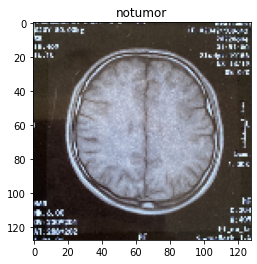

In [ ]:
#model = load_model('first_model.h5') 
img_path = '/content/gdrive/MyDrive/brain1.jpg'
predicted_class = predict_class(model, img_path)


1/1 [==============================] - 0s 45ms/step
Prediction: notumor


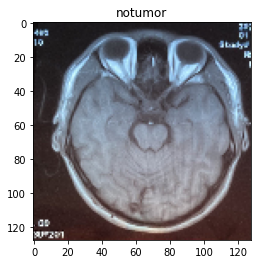

In [ ]:
img_path2 = '/content/gdrive/MyDrive/brain2.jpg'
predicted_class = predict_class(model2, img_path2)


1/1 [==============================] - 0s 212ms/step
Prediction: notumor


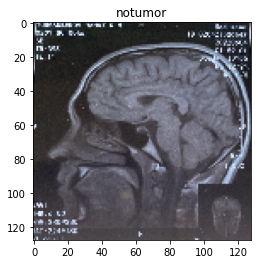

In [ ]:
img_path3 = '/content/gdrive/MyDrive/brain3.jpg'
predicted_class = predict_class(model3, img_path3)
